In [22]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

Uniform noise addition function

In [23]:
# Gaussian noise addition function
def add_gaussian_noise(img):
    img=img.astype(np.float32)
    mean=0
    var=10
    noise=np.random.normal(mean, var, img.shape)
    img = img + noise
    return img


In [24]:
#Here we load the dataset from keras
(train_imgs,_),(test_imgs,_)=mnist.load_data()

In [25]:
# Iterate over the images to add the noise
train_imgs_noisy = np.zeros((60000,28,28))

for idx in tqdm(range(len(train_imgs))):
    train_imgs_noisy[idx]=add_gaussian_noise(train_imgs[idx])

print("Added noise to train images")

test_imgs_noisy = np.zeros((10000,28,28))

for idx in tqdm(range(len(test_imgs))):
    test_imgs_noisy[idx]=add_gaussian_noise(test_imgs[idx])

print("Added noise to test images")

100%|██████████| 60000/60000 [00:06<00:00, 9942.89it/s]


Added noise to train images


100%|██████████| 10000/10000 [00:00<00:00, 11000.77it/s]

Added noise to test images


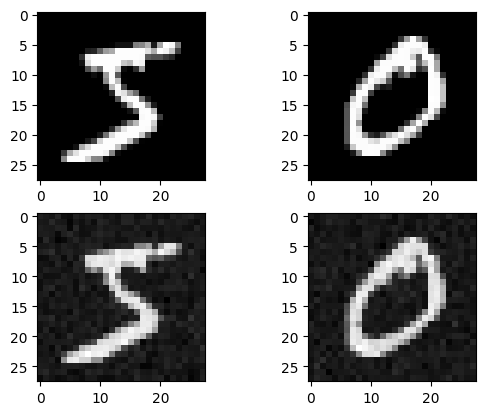

In [26]:
# Show some clean/dirty couples
f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(train_imgs[0],cmap="gray")
axes[1,0].imshow(train_imgs_noisy[0],cmap='gray')

#showing images with speckle noise
axes[0,1].imshow(train_imgs[1],cmap='gray')
axes[1,1].imshow(train_imgs_noisy[1],cmap="gray")


In [27]:
# Create dataset class
class NoisyVsOriginalDataset(Dataset):

  def __init__(self,noisy,original,transform):
    self.noisy = noisy
    self.original = original
    self.transform = transform

  def __len__(self):
    return len(self.original)

  def __getitem__(self,idx):
    noisy = self.noisy[idx]
    original = self.original[idx]

    if self.transform != None:
      noisy = self.transform(noisy)
      original = self.transform(original)

    return (noisy,original)

In [28]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

train_set = NoisyVsOriginalDataset(train_imgs_noisy, train_imgs, transforms)
test_set = NoisyVsOriginalDataset(test_imgs_noisy, test_imgs_noisy, transforms)

In [29]:
# Create loaders
batch_size = 32

train_set_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_set_loader = DataLoader(test_set, batch_size=1, shuffle=True)


In [30]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [37]:
# Define model

class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,512),
                  nn.ReLU(True),
                  nn.Linear(512,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
                  )

    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,512),
                  nn.ReLU(True),
                  nn.Linear(512,28*28),
                  nn.Sigmoid(),
                  )

  def forward(self, image):
    image = self.encoder(image)
    image = self.decoder(image)

    return image

denoising_autoencoder = DenoisingAutoencoder().to(device)

In [38]:
# Define a loss function

loss_fn = nn.MSELoss()
optimizer = optim.SGD(denoising_autoencoder.parameters(), lr=0.01, weight_decay=1e-5)

In [ ]:
epochs=20
losses = list()
epoch_loss = 0
running_loss = 0
for epoch in range(epochs):

  print("Entering Epoch: ",epoch)
  for dirty,clean in tqdm((train_set_loader)):


    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)



    #-----------------Forward Pass----------------------
    output=denoising_autoencoder(dirty)
    loss=loss_fn(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    epoch_loss+=loss.item()
  #-----------------Log-------------------------------
  losses.append(running_loss/len(train_set_loader))
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))


Entering Epoch:  0


100%|██████████| 1875/1875 [00:32<00:00, 57.16it/s]


======> epoch: 0/20, Loss:0.03811536356806755
Entering Epoch:  1


100%|██████████| 1875/1875 [00:20<00:00, 92.37it/s]


======> epoch: 1/20, Loss:0.033416759222745895
Entering Epoch:  2


100%|██████████| 1875/1875 [00:21<00:00, 87.59it/s]


======> epoch: 2/20, Loss:0.03336882218718529
Entering Epoch:  3


 85%|████████▌ | 1598/1875 [00:17<00:02, 96.54it/s]

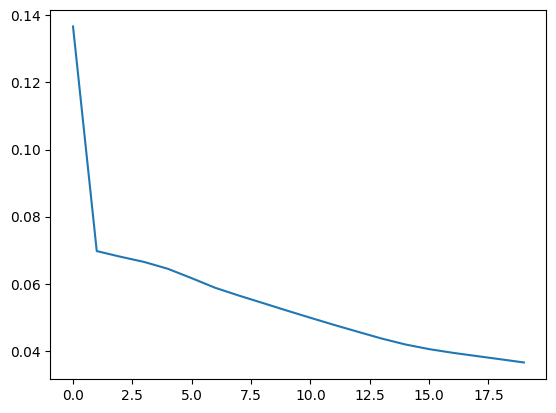

In [40]:
plt.plot(range(len(losses)), losses)

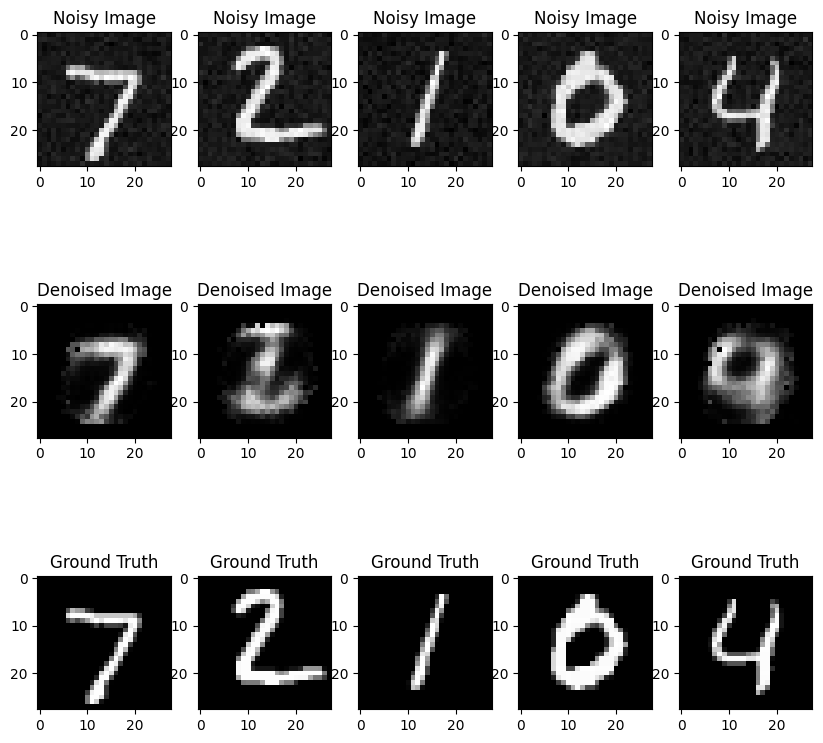

In [41]:
# Take 10 noisy images from the test dataset
noisy_images = test_imgs_noisy[:5]

# Use the denoising autoencoder to denose the images
denoised_images = []
for image in noisy_images:
  image = torch.tensor(image).view(1, -1).type(torch.FloatTensor).to(device)
  denoised_image = denoising_autoencoder(image).cpu().data.numpy().reshape(28, 28)
  denoised_images.append(denoised_image)

# Plot the noisy images alongside the denoised images and the ground truth
f, axes = plt.subplots(3, 5, figsize=(10, 10))
for i in range(5):
  axes[0, i].imshow(noisy_images[i], cmap="gray")
  axes[0, i].set_title("Noisy Image")
  axes[1, i].imshow(denoised_images[i], cmap="gray")
  axes[1, i].set_title("Denoised Image")
  axes[2, i].imshow(test_imgs[i], cmap="gray")
  axes[2, i].set_title("Ground Truth")

plt.show()
